In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.metrics import balanced_accuracy_score as BACC
import tensorflow as tf
import keras.backend as K


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Processing

In [42]:
def load_dias():
    X = np.load('/content/drive/MyDrive/ML/Lab4/Xtrain_Classification2.npy') #10629 x 2352 2D array
    y = np.load('/content/drive/MyDrive/ML/Lab4/ytrain_Classification2.npy') #10629 x 1 1D array
    X_t = np.load('/content/drive/MyDrive/ML/Lab4/Xtest_Classification2.npy') #2658 x 2352 2D array
    return X, y, X_t

def load_dudu():
    X = np.load('Xtrain_Classification2.npy') #10629 x 2352 2D array
    y = np.load('ytrain_Classification2.npy') #10629 x 1 1D array
    X_t = np.load('Xtest_Classification2.npy') #2658 x 2352 2D array
    return X, y, X_t

def data_pre_processing(X, X_t):
    Xscaled = (X).astype('float32')/np.max(X) #Scale down data [0,1]
    Xscaled_test = (X_t).astype('float32')/np.max(X)
    return Xscaled, Xscaled_test

def encoding(Xscaled, Xscaled_test):
    train_labels = keras.utils.to_categorical(y,num_classes=6) #One-hot enconding
    train_images = np.reshape(Xscaled, (len(Xscaled[:,0]),28,28,3)) #4D array. number of images x width x height x color
    test_images = np.reshape(Xscaled_test, (len(Xscaled_test[:,0]), 28, 28, 3))
    return train_labels, train_images, test_images

def shuffling(Xscaled, train_images, train_labels):
    permutation = np.random.permutation(len(Xscaled[:,0])) #No shuffling done for test images
    train_images_s = train_images[permutation]
    train_labels_s = train_labels[permutation]
    return train_images_s, train_labels_s

def number_per_class(y):
    print('Número de imagens da  classe 0:', np.count_nonzero(y==0))
    print('Número de imagens da classe 1:', np.count_nonzero(y==1))
    print('Número de imagens da classe 2:', np.count_nonzero(y==2))
    print('Número de imagens da classe 3:', np.count_nonzero(y==3))
    print('Número de imagens da classe 4:', np.count_nonzero(y==4))
    print('Número de imagens da classe 5:', np.count_nonzero(y==5))

X, y, X_t = load_dias()
print(X.shape,y.shape, X_t.shape)
Xscaled, Xscaled_test = data_pre_processing(X, X_t)
train_labels, train_images, test_images = encoding(Xscaled, Xscaled_test)
train_images_s, train_labels_s = shuffling(Xscaled, train_images, train_labels)
X_train, X_validation, y_train, y_validation = train_test_split(train_images_s, train_labels_s, test_size=0.2)


(10629, 2352) (10629,) (2658, 2352)


In [ ]:
number_per_class(y)

Número de imagens da  classe 0: 5362
Número de imagens da classe 1: 890
Número de imagens da classe 2: 116
Número de imagens da classe 3: 2305
Número de imagens da classe 4: 990
Número de imagens da classe 5: 966


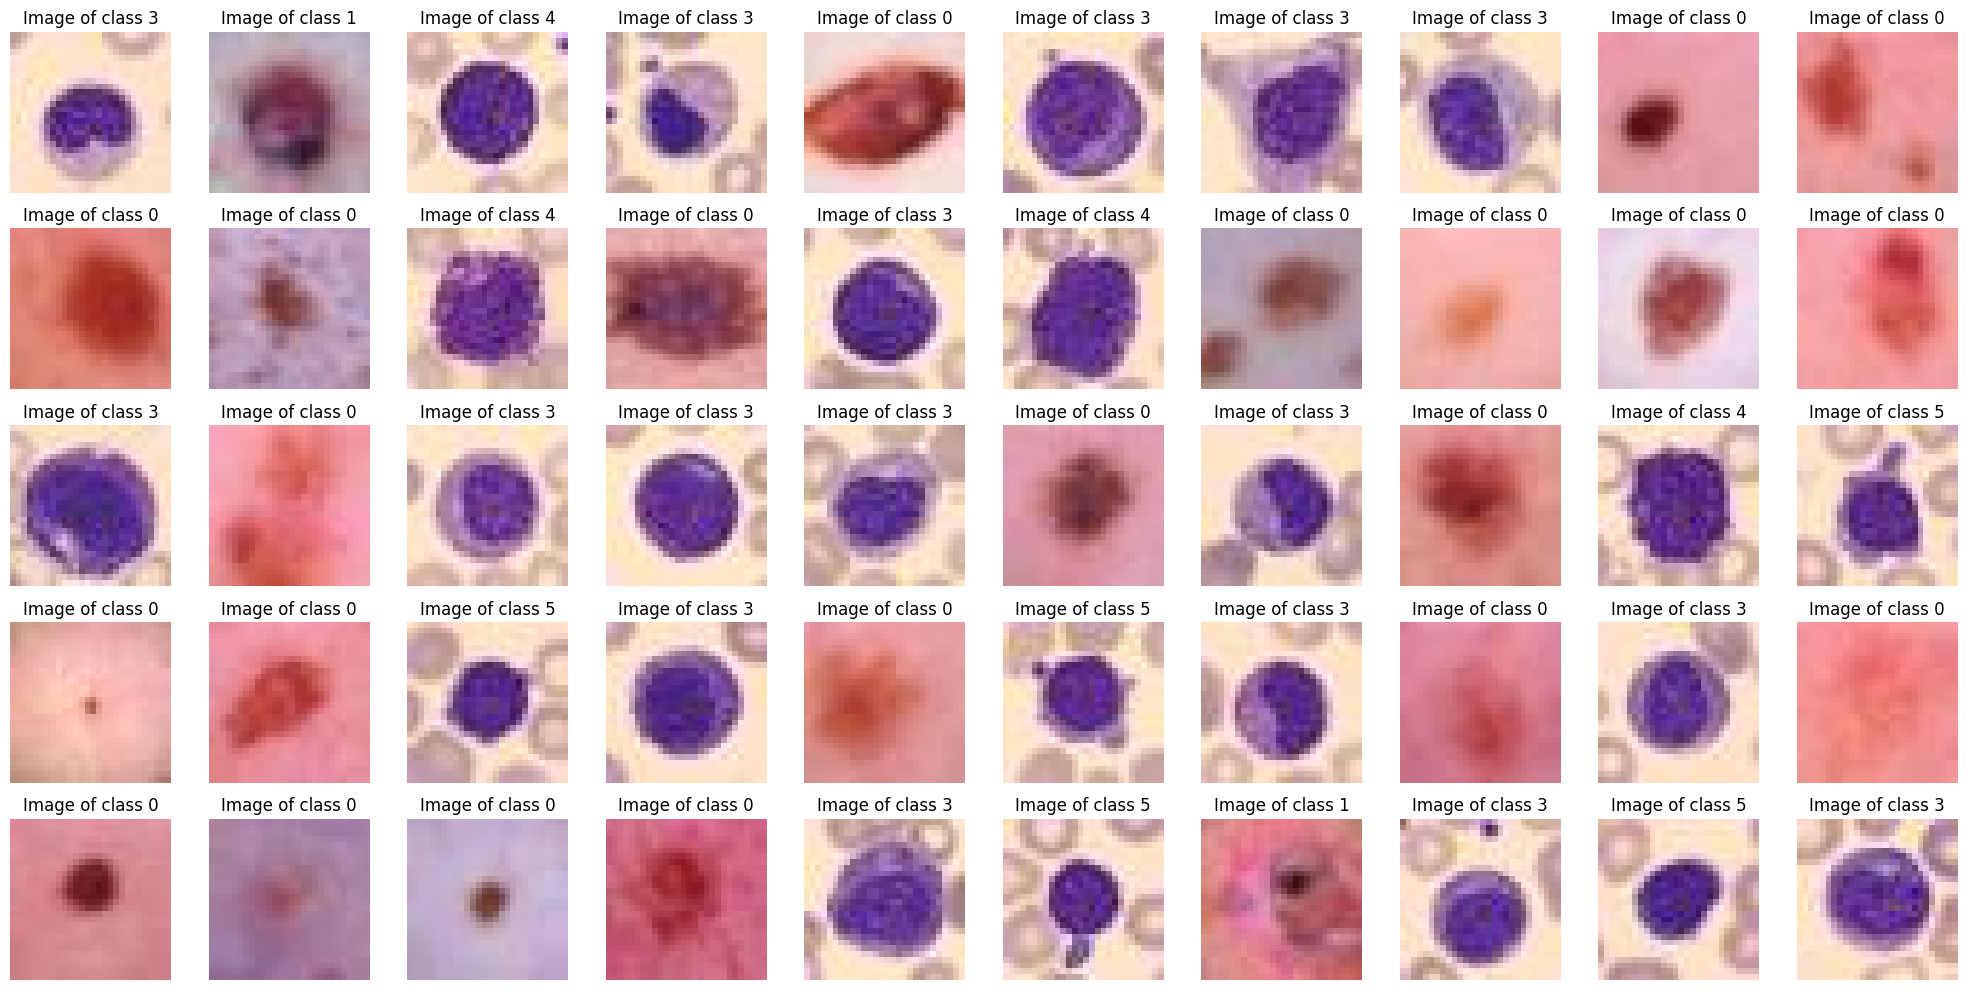

In [ ]:
#plot images
number_images = 50
plt.figure(figsize=(20, 10))
for i in range(number_images):
    plt.subplot(5, 10, i + 1)
    plt.imshow(train_images[i])
    label = int(y[i])
    plt.title(f"Image of class {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Metrics for validation

In [9]:
#Metrics
def specificity_custom(y_pred_onehot, y_true_onehot):
    """ How well can identify true negatives """
    y_pred = tf.argmax(y_pred_onehot, axis=1)
    y_true = tf.argmax(y_true_onehot, axis=1)
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = tf.reduce_sum(tf.cast(neg_y_true, dtype=tf.float32) * tf.cast(y_pred, dtype=tf.float32))  # false positives
    tn = tf.reduce_sum(tf.cast(neg_y_true, dtype=tf.float32) * tf.cast(neg_y_pred, dtype=tf.float32))  # true negatives
    if fp + tn == 0:
        return 0.0
    return tn / (tn + fp)

# One hot enconding -> ["apple", "banana", "cherry"].
# "apple" becomes [1, 0, 0], "banana" becomes [0, 1, 0], "cherry" becomes [0, 0, 1]
def sensitivity_custom(y_pred_onehot, y_true_onehot):
    """ How well can identify true positives """
    y_pred = tf.argmax(y_pred_onehot, axis=1) # sensitivity(recall)
    y_true = tf.argmax(y_true_onehot, axis=1)
    neg_y_pred = 1 - y_pred
    fn = tf.reduce_sum(tf.cast(neg_y_pred, dtype=tf.float32) * tf.cast(y_true, dtype=tf.float32))
    tp = tf.reduce_sum(tf.cast(y_true, dtype=tf.float32) * tf.cast(y_pred, dtype=tf.float32))
    if tp + fn == 0:
        return 0.0
    return tp / (tp + fn)

def balanced_accuracy_custom(y_pred_onehot, y_true_onehot):
    """ Average of specificity and sensitivity """
    specificity_val = specificity_custom(y_pred_onehot, y_true_onehot)
    sensitivity_val = sensitivity_custom(y_pred_onehot, y_true_onehot)
    return (specificity_val + sensitivity_val) / 2

def f1_score_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    return f1_score(y_true, y_pred, average='weighted')

def sensitivity_metric(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(y_true * y_pred))
    actual_positives = tf.reduce_sum(y_true)
    return true_positives / (actual_positives + tf.keras.backend.epsilon())

def balanced_accuracy_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    return balanced_accuracy_score(y_true, y_pred)


def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)[1]
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)[1]
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)[1]
    precision = true_positives / (predicted_positives)
    recall = true_positives / (possible_positives)
    f1_val = 2*(precision*recall)/(precision+recall)
    return f1_val

def bacc(cnn_model, X, y_real):
    y_pred = cnn_model.predict(X_validation)
    #Convert one-hot encoded true/predictions labels to categorical labels
    y_true_labels = np.argmax(y_validation, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    bacc = BACC(y_true_labels, y_pred_labels)
    return bacc

## Data Augmentation

In [10]:
def data_augment(Xtrain):

    data_augmentation = tf.keras.Sequential([
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.2, fill_mode='nearest'),
        ])
    # plt.figure()
    # plt.imshow(Xtrain[500])
    train_dataset = tf.data.Dataset.from_tensor_slices(Xtrain)
    Xtrain = train_dataset.map(lambda x: data_augmentation(x))
    Xtrain = np.array(list(Xtrain))
    # plt.figure()
    # plt.imshow(Xtrain[500])
    # plt.show()
    return Xtrain

## Convolution Neural Network's

In [11]:
def CNN_1():
    cnn = keras.Sequential([
        keras.layers.Conv2D(32, kernel_size =(3,3), padding='same', activation='relu', input_shape=(28,28,3)),
        keras.layers.Conv2D(32,(3,3),activation='relu', padding='same'),
        keras.layers.AveragePooling2D(pool_size=(2,2), strides=2),
        keras.layers.Dropout(0.25),
        keras.layers.Conv2D(64,(3,3),activation='relu', padding='same'),
        keras.layers.AveragePooling2D(pool_size=(2,2), strides=2),
        keras.layers.Dropout(0.25),
        keras.layers.Conv2D(128,(3,3),activation='relu', padding='same'),
        keras.layers.AveragePooling2D(pool_size=(2,2),strides=2),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(256,activation='relu'),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(256,activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(6,activation='softmax')
        ])
    cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[keras.metrics.F1Score()])
    #cnn.summary() #See created neural network
    return cnn

def CNN_2():
    cnn_model2 =cnn = keras.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(6, activation='softmax')
    ])

    cnn_model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[keras.metrics.F1Score()])
    return cnn_model2

def create_lenet_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(6, (5, 5), activation='relu', input_shape=(28, 28, 3)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(120, activation='relu'))
    model.add(keras.layers.Dense(84, activation='relu'))
    model.add(keras.layers.Dense(6, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[keras.metrics.F1Score()])
    return model

def Improved_CNN():
    #Replaced AveragePooling2D with MaxPooling2D for better feature selection.
    #Simplified by fewer dropout layers.
    cnn = keras.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(28, 28, 3)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(6, activation='softmax')
    ])

    cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.F1Score()])
    return cnn


## Training of CNN

In [12]:
def class_weights(y_train):
    y_train_int = tf.argmax(y_train, axis=1)
    y_train_int_np = y_train_int.numpy()
    weights = compute_class_weight('balanced', classes=np.unique(y_train_int_np), y=y_train_int_np)
    class_weights = {i: weights[i] for i in range(len(weights))}
    return class_weights

def learning_rate_scheduler_function(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * 0.95  # Adjust the rate as needed

lr_callback = LearningRateScheduler(learning_rate_scheduler_function)

def train_model_class_weights(cnn, X_train, y_train, X_validation, y_validation, in_verbose):
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) #Patince is the number of epochs whithout improvements
    history = cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                   batch_size=512, epochs=200, shuffle=True, verbose=in_verbose, callbacks=[early_stop],
                   class_weight=class_weights(y_train))
    return history

def train_model(cnn, X_train, y_train, X_validation, y_validation, in_verbose):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) #Patince is the number of epochs whithout improvements
    history = cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                   batch_size=512, epochs=200, shuffle=True, verbose=in_verbose, callbacks=[early_stop, lr_callback])
    return history

In [13]:
def plot(history):
    plt.figure(figsize=(15, 5))  # Increase the figure size

    # Create the first subplot (Loss)
    plt.subplot(2, 2, 1)  # Create a subplot with 1 row and 3 columns, and select the first subplot
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Create the second subplot (F1 Score)
    plt.subplot(2, 2, 2)  # Select the second subplot
    plt.plot(history.history['f1_score'], 'g', label='Training F1 Score')
    plt.plot(history.history['val_f1_score'], 'r', label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()

    # # Create the third subplot (Balanced Accuracy)
    # plt.subplot(2, 2, 3)  # Select the third subplot
    # plt.plot(history.history['balanced_accuracy_custom'], 'b', label='Training Balanced Accuracy')
    # plt.plot(history.history['val_balanced_accuracy_custom'], 'y', label='Validation Balanced Accuracy')
    # plt.xlabel('Epoch')
    # plt.ylabel('Balanced Accuracy')
    # plt.title('Training and Validation Balanced Accuracy')
    # plt.legend()

    # # Create the third subplot (Balanced Accuracy)
    # plt.subplot(2, 2, 4)  # Select the third subplot
    # plt.plot(history.history['sensitivity_custom'], 'b', label='Training Sensitivity Accuracy')
    # plt.plot(history.history['val_sensitivity_custom'], 'y', label='Validation Sensitivity Accuracy')
    # plt.xlabel('Epoch')
    # plt.ylabel('Sensitivity Accuracy')
    # plt.title('Training and Validation Sensitivity Accuracy')
    # plt.legend()

    plt.tight_layout()  # Ensure that the subplots don't overlap
    plt.show()

def check_results(history):
    plot(history)
    print("Train - Loss: {:.4f}".format(history.history['loss'][-1]))
    print("Test  - Val Loss: {:.4f}".format(np.mean(history.history['val_loss'][-1])))
    train_f1_score = np.mean(history.history['f1_score'])
    val_f1_score = np.mean(history.history['val_f1_score'])
    print("Train - Mean F1 Score: {:.4f}".format(train_f1_score))
    print("Test - Mean Val F1 Score: {:.4f}".format(val_f1_score))
    # train_sensitivity = history.history['sensitivity_custom'][-1]
    # val_sensitivity = history.history['val_sensitivity_custom'][-1]
    # print("Train - Final Sensitivity: {:.4f}".format(train_sensitivity))
    # print("Test - Final Val Sensitivity: {:.4f}".format(val_sensitivity))
    # train_balanced_accuracy = history.history['balanced_accuracy_custom'][-1]
    # val_balanced_accuracy = history.history['val_balanced_accuracy_custom'][-1]
    # print("Train - Final Balanced Accuracy: {:.4f}".format(train_balanced_accuracy))
    # print("Test - Final Val Balanced Accuracy: {:.4f}".format(val_balanced_accuracy))

### Data augmentation

In [16]:
from keras.preprocessing.image import ImageDataGenerator

def data_augmentation(X_train, y_train, batch_size):
    # Create an instance of the ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,      # Random rotation within ±20 degrees
        width_shift_range=0.2,  # Random horizontal shift within ±20% of the width
        height_shift_range=0.2, # Random vertical shift within ±20% of the height
        shear_range=0.2,        # Shearing transformation within ±20 degrees
        zoom_range=0.2,         # Random zooming within ±20%
        horizontal_flip=True,   # Random horizontal flipping
        fill_mode='nearest'     # Fill points outside the boundaries with the nearest value
    )

    # Generate augmented data and labels
    augmented_data = []
    augmented_labels = []
    num_augmented_samples = len(X_train) * batch_size

    for _ in range(batch_size):
        for x, y in datagen.flow(X_train, y_train, batch_size=len(X_train)):
            augmented_data.extend(x)
            augmented_labels.extend(y)
            if len(augmented_data) >= num_augmented_samples:
                break

    # Convert the augmented data and labels to numpy arrays
    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)

    return augmented_data, augmented_labels

### Balanced generator

In [15]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight

def data_balance_generator(Xtrain, train_labels, num_classes):
    Xtrain = Xtrain.reshape(-1, 28, 28, 3) # Reshape the input data

    train_labels = np.argmax(train_labels, axis=1) # Convert one-hot encoded labels to categorical labels (0 to num_classes-1)
    train_labels = tf.cast(train_labels, dtype=tf.float32)

    train_labels = keras.utils.to_categorical(train_labels, num_classes) # Reshape the labels back to one-hot encoding

    # Use RandomOverSampler to balance the dataset
    ros = RandomOverSampler(sampling_strategy='auto')
    X_resampled, y_resampled = ros.fit_resample(Xtrain.reshape(-1, 28 * 28 * 3), train_labels)

    X_resampled = X_resampled.reshape(-1, 28, 28, 3) # Reshape X_resampled back to its original shape

    return X_resampled, y_resampled


def train_model_class_weights_ag(cnn, X_train, y_train, X_validation, y_validation, in_verbose):
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)  # Cast y_train to float32
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                      batch_size=512, epochs=200, shuffle=True, verbose=in_verbose,
                      callbacks=[early_stop, lr_callback], class_weight=class_weights(y_train))
    return history

### CNN 1 with imbalanced data

In [ ]:
cnn1 = CNN_1()
without_class_weights = train_model(cnn1, X_train, y_train, X_validation, y_validation, 0)

67/67 [==============================] - 1s 15ms/step - loss: 0.4106 - f1_score: 0.5440
Test f1: [0.91404253 0.         0.         0.8700906  0.65798044 0.8220551 ]


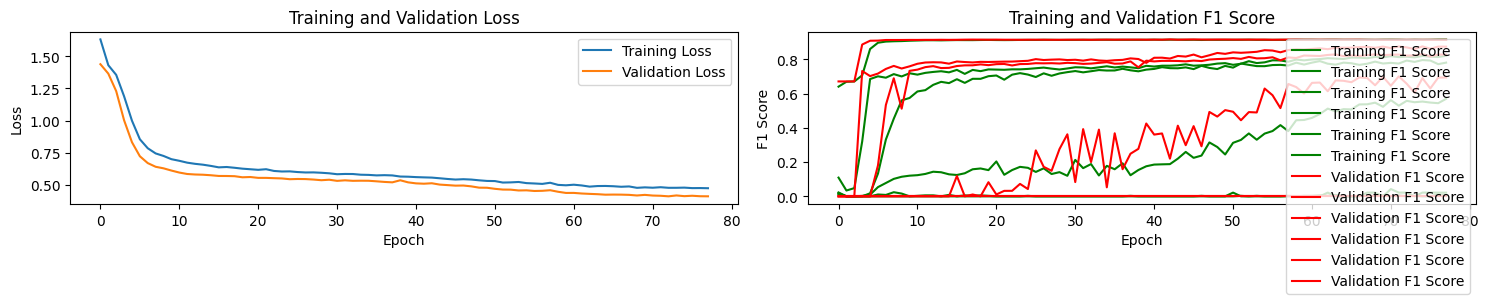

Train - Loss: 0.4736
Test  - Val Loss: 0.4107
Train - Mean F1 Score: 0.4293
Test - Mean Val F1 Score: 0.4573
67/67 [==============================] - 1s 4ms/step
Balanced Accuracy: 0.5496575502571295


In [ ]:
test_eval = cnn1.evaluate(X_validation, y_validation, verbose=1)
print('Test f1:', test_eval[1])
check_results(without_class_weights)
bacc_final = bacc(cnn1, X_validation, y_validation)
print('Balanced Accuracy:', bacc_final)

### CNN 1 with class weights

In [ ]:
cnn1_weights = CNN_1()
with_class_weights = train_model_class_weights(cnn1_weights, X_train, y_train, X_validation, y_validation, 0)

67/67 [==============================] - 0s 5ms/step - loss: 0.5144 - f1_score: 0.6685
Test f1: [0.78551835 0.41562498 0.45652172 0.8151659  0.6744731  0.86384976]


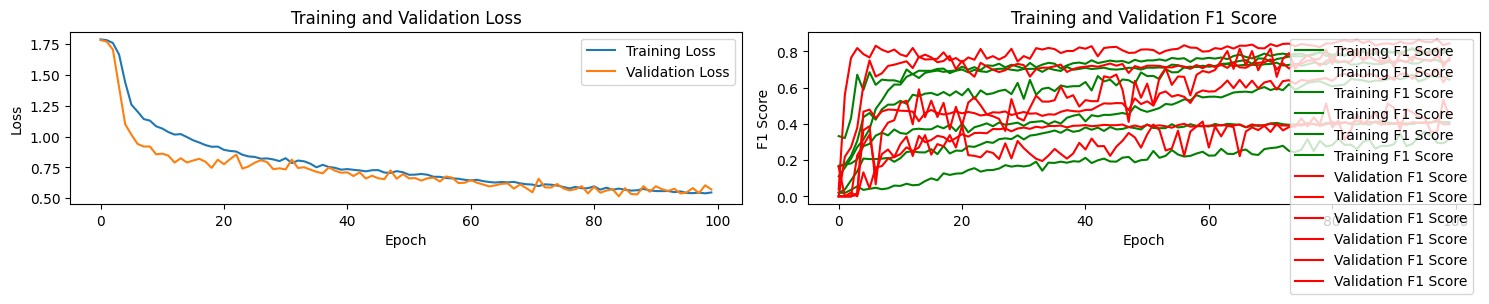

Train - Loss: 0.5457
Test  - Val Loss: 0.5703
Train - Mean F1 Score: 0.5151
Test - Mean Val F1 Score: 0.5496
67/67 [==============================] - 1s 5ms/step
Balanced Accuracy: 0.782708553298559


In [ ]:
test_eval_2 = cnn1_weights.evaluate(X_validation, y_validation, verbose=1)
print('Test f1:', test_eval_2[1])
check_results(with_class_weights)
bacc_final = bacc(cnn1_weights, X_validation, y_validation)
print('Test Balanced Accuracy:', bacc_final)

bacc_final = bacc(cnn1_weights, X_train, y_train)
print('Train Balanced Accuracy:', bacc_final)

### Lenet Model with class weights

In [ ]:
lenet_model = create_lenet_model()
lenet_model_weights = train_model_class_weights(lenet_model, X_train, y_train, X_validation, y_validation, 0)

67/67 [==============================] - 0s 4ms/step - loss: 0.6896 - f1_score: 0.5718
Test f1: [0.80041796 0.3308642  0.16309012 0.75302666 0.5860465  0.79729736]


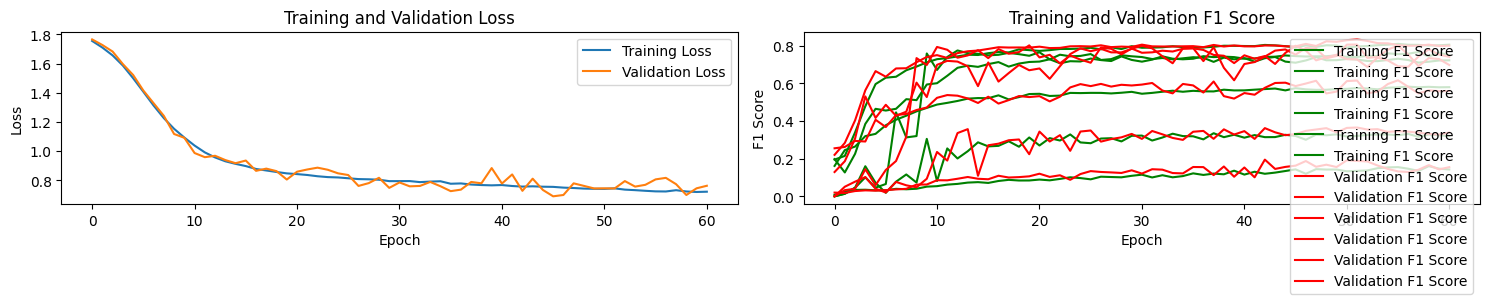

Train - Loss: 0.7213
Test  - Val Loss: 0.7621
Train - Mean F1 Score: 0.4920
Test - Mean Val F1 Score: 0.5048
67/67 [==============================] - 0s 2ms/step
Balanced Accuracy: 0.681370984811418


In [ ]:
test_eval_lenet = lenet_model.evaluate(X_validation, y_validation, verbose=1)
print('Test f1:', test_eval_lenet[1])
check_results(lenet_model_weights)

bacc_final = bacc(lenet_model, X_validation, y_validation)
print('Test Balanced Accuracy:', bacc_final)

bacc_final = bacc(lenet_model, X_train, y_train)
print('Train Balanced Accuracy:', bacc_final)

### CNN 2 with class weights

In [ ]:
cnn_model2 = CNN_2()
cnn_model2_with_class_weights = train_model_class_weights(cnn_model2, X_train, y_train, X_validation, y_validation, 0)

67/67 [==============================] - 0s 3ms/step - loss: 0.5393 - f1_score: 0.7003
Test f1: [0.7717934  0.42670536 0.5846154  0.86238533 0.7258883  0.83062637]


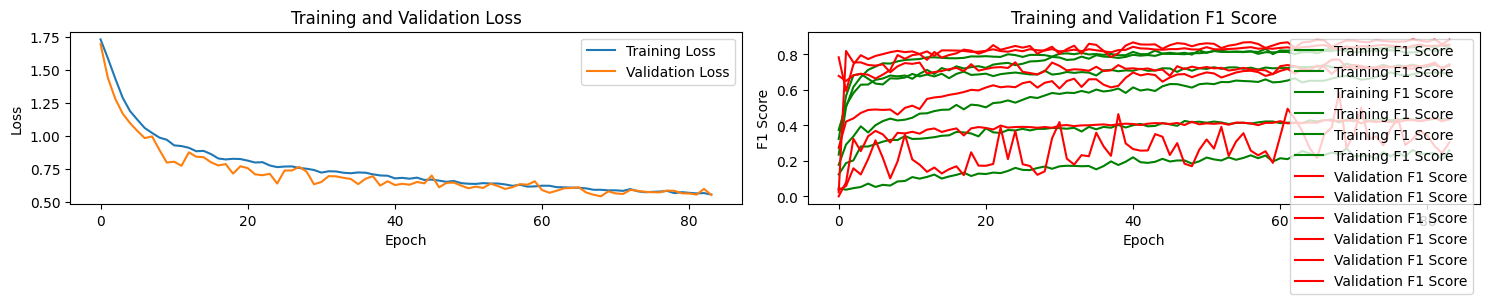

Train - Loss: 0.5530
Test  - Val Loss: 0.5495
Train - Mean F1 Score: 0.5661
Test - Mean Val F1 Score: 0.6117
67/67 [==============================] - 0s 2ms/step
Balanced Accuracy: 0.7856220590418825


In [ ]:
test_cnn2 = cnn_model2.evaluate(X_validation, y_validation, verbose=1)
print('Test f1:', test_cnn2[1])
check_results(cnn_model2_with_class_weights)

bacc_final = bacc(cnn_model2, X_validation, y_validation)
print('Test Balanced Accuracy:', bacc_final)

bacc_final = bacc(cnn_model2, X_train, y_train)
print('Train Balanced Accuracy:', bacc_final)

### CNN1 with data augmentation and class weights

In [ ]:
cnn1_augmentation = CNN_1() #to increase data diversity
X_ag, y_ag = data_augmentation(X_train, y_train, 2)
cnn_augmentation_history = train_model_class_weights(cnn1_augmentation, X_ag, y_ag, X_validation, y_validation, 0)

67/67 [==============================] - 0s 3ms/step - loss: 0.4964 - f1_score: 0.7095
Test f1: [0.8010929  0.45581397 0.556962   0.8551565  0.71394795 0.8737864 ]


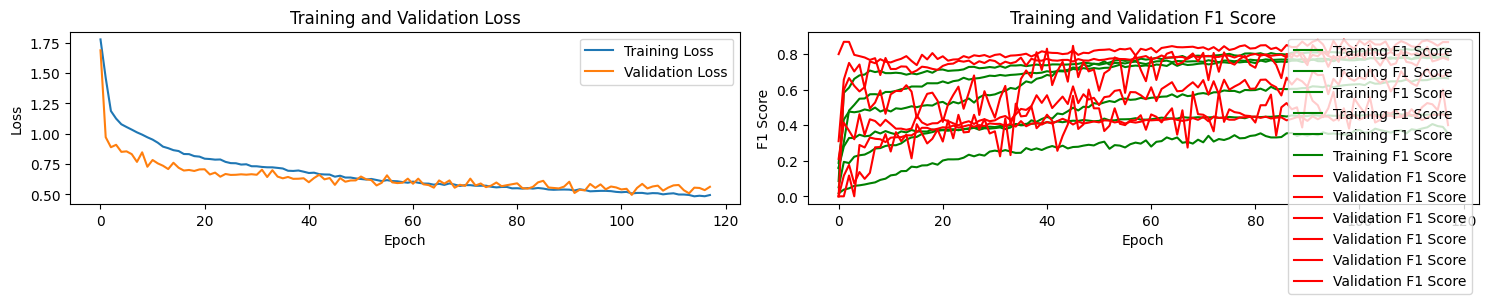

Train - Loss: 0.4951
Test  - Val Loss: 0.5627
Train - Mean F1 Score: 0.5554
Test - Mean Val F1 Score: 0.6066
67/67 [==============================] - 0s 2ms/step
Balanced Accuracy: 0.8170897670242582


In [ ]:
test_cnn_augmentation = cnn1_augmentation.evaluate(X_validation, y_validation, verbose=1)
print('Test f1:', test_cnn_augmentation[1])
check_results(cnn_augmentation_history)
bacc_final = bacc(cnn1_augmentation, X_validation, y_validation)
print('Test - Balanced Accuracy:', bacc_final)
bacc_final = bacc(cnn1_augmentation, X_train, y_train)
print('Train - Balanced Accuracy:', bacc_final)

### CNN 2 with balanced data(oversampling) and class weights

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight

def data_balance_generator(Xtrain, train_labels, num_classes):
    Xtrain = Xtrain.reshape(-1, 28, 28, 3) # Reshape the input data

    train_labels = np.argmax(train_labels, axis=1) # Convert one-hot encoded labels to categorical labels (0 to num_classes-1)
    train_labels = tf.cast(train_labels, dtype=tf.float32)

    train_labels = keras.utils.to_categorical(train_labels, num_classes) # Reshape the labels back to one-hot encoding

    # Use RandomOverSampler to balance the dataset
    ros = RandomOverSampler(sampling_strategy='auto')
    X_resampled, y_resampled = ros.fit_resample(Xtrain.reshape(-1, 28 * 28 * 3), train_labels)

    X_resampled = X_resampled.reshape(-1, 28, 28, 3) # Reshape X_resampled back to its original shape

    return X_resampled, y_resampled

def train_model_class_weights_ag(cnn, X_train, y_train, X_validation, y_validation, in_verbose):
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)  # Cast y_train to float32
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                      batch_size=512, epochs=200, shuffle=True, verbose=in_verbose,
                      callbacks=[early_stop, lr_callback], class_weight=class_weights(y_train))
    return history
cnn2_aug = CNN_2()
X_train_ag, y_train_ag = data_balance_generator(X_train, y_train, 6)
cnn_model2_with_class_weights = train_model_class_weights_ag(cnn2_aug, X_train_ag, y_train_ag, X_validation, y_validation, 0)


67/67 [==============================] - 0s 3ms/step - loss: 0.4093 - f1_score: 0.7387
Test f1: [0.8375262  0.49275365 0.4731183  0.90967745 0.83977896 0.87960684]


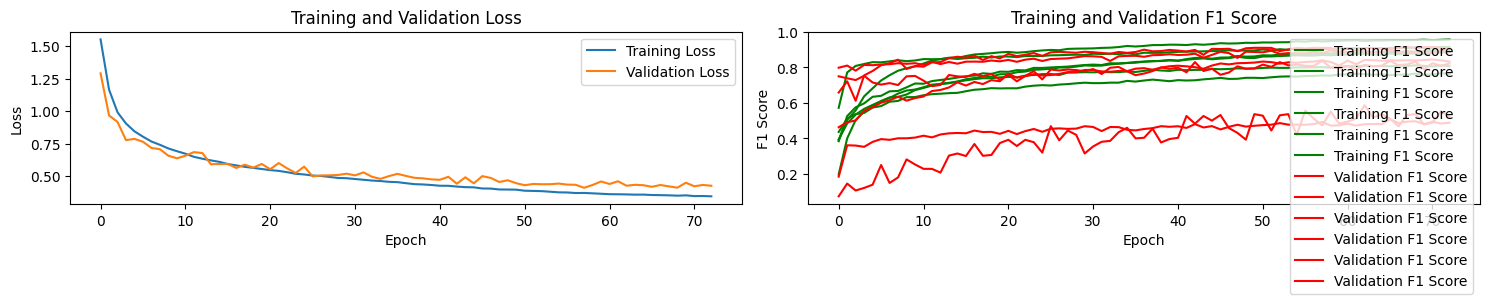

Train - Loss: 0.3435
Test  - Val Loss: 0.4249
Train - Mean F1 Score: 0.7997
Test - Mean Val F1 Score: 0.6855
67/67 [==============================] - 0s 2ms/step
Balanced Accuracy: 0.8364595296949666


In [ ]:
test_cnn2_augmentation = cnn2_aug.evaluate(X_validation, y_validation, verbose=1)
print('Test f1:', test_cnn2_augmentation[1])
check_results(cnn_model2_with_class_weights)
bacc_final = bacc(cnn2_aug, X_validation, y_validation)
print('Test - Balanced Accuracy:', bacc_final)
bacc_final = bacc(cnn2_aug, X_train, y_train)
print('Train - Balanced Accuracy:', bacc_final)

### CNN1 with balanced data(oversampling) and class weights

In [ ]:
cnn1_aug_weights = CNN_1()
X_train_ag, y_train_ag = data_balance_generator(X_train, y_train, 6)
cnn_model1_with_class_weights_ag = train_model_class_weights_ag(cnn1_aug_weights, X_train_ag, y_train_ag, X_validation, y_validation, 0)

67/67 [==============================] - 0s 4ms/step - loss: 0.4136 - f1_score: 0.7399
Test f1: [0.8154922  0.4836601  0.50602406 0.8886311  0.82608694 0.91943127]


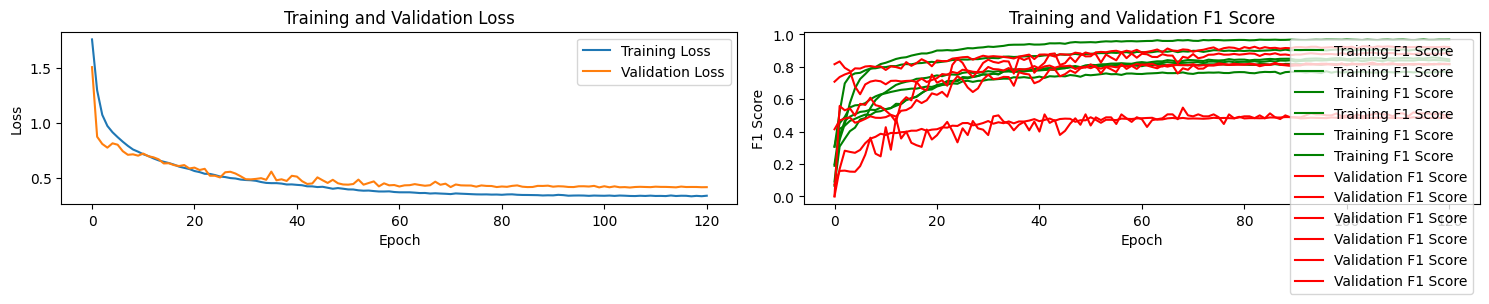

Train - Loss: 0.3390
Test  - Val Loss: 0.4170
Train - Mean F1 Score: 0.8010
Test - Mean Val F1 Score: 0.6852
67/67 [==============================] - 0s 3ms/step
Balanced Accuracy: 0.8500395376901362


In [ ]:
test_cnn1_augmentation_w = cnn1_aug_weights.evaluate(X_validation, y_validation, verbose=1)
print('Test f1:', test_cnn1_augmentation_w[1])
check_results(cnn_model1_with_class_weights_ag)
bacc_final = bacc(cnn1_aug_weights, X_validation, y_validation)
print('Test - Balanced Accuracy:', bacc_final)

bacc_final = bacc(cnn1_aug_weights, X_train, y_train)
print('Train - Balanced Accuracy:', bacc_final)

### Improved CNN with balanced data(oversampling)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

def train_model_class_weights(cnn, X_train, y_train, X_validation, y_validation, in_verbose):
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7) #callback used to dynamically adjust the learning rate during training.
    tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)  # visualization tool for monitoring and debugging the training process

    # Define class weights only if you didn't provide them before
    if 'class_weight' not in cnn.compile_params:
        class_weights = compute_class_weight('balanced', np.unique(np.argmax(y_train, axis=1)), np.argmax(y_train, axis=1))
        class_weights = dict(enumerate(class_weights))
    else:
        class_weights = cnn.compile_params['class_weight']

    history = cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                      batch_size=512, epochs=200, shuffle=True, verbose=in_verbose,
                      callbacks=[early_stop, reduce_lr, tensorboard], class_weight=class_weights)

    return history
cnn_improved = Improved_CNN()
X_train_ag, y_train_ag = data_balance_generator(X_train, y_train, 6)
cnn_model_improved_history = train_model_class_weights_ag(cnn_improved, X_train_ag, y_train_ag, X_validation, y_validation, 0)

67/67 [==============================] - 1s 5ms/step - loss: 0.3406 - categorical_accuracy: 0.8358 - f1_score: 0.7847
Test categorical: 0.835841953754425
Test f1: [0.86314714 0.518797   0.6        0.9260524  0.87317073 0.92682934]


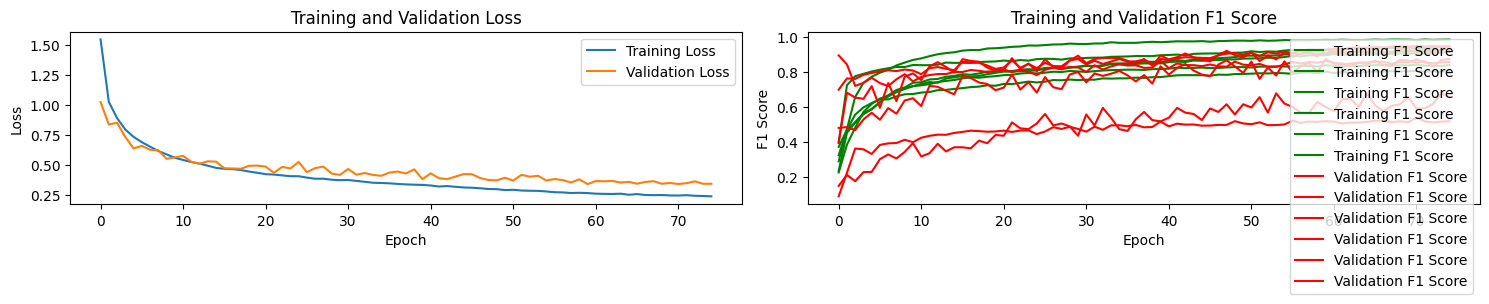

Train - Loss: 0.2388
Test  - Val Loss: 0.3430
Train - Mean F1 Score: 0.8286
Test - Mean Val F1 Score: 0.7125
67/67 [==============================] - 0s 2ms/step
Balanced Accuracy: 0.8662268175763472


In [ ]:
test_cnn1_improved_w = cnn_improved.evaluate(X_validation, y_validation, verbose=1)
print('Test categorical:', test_cnn1_improved_w[1])
print('Test f1:', test_cnn1_improved_w[2])

check_results(cnn_model_improved_history)
bacc_final = bacc(cnn_improved , X_validation, y_validation)
print('Balanced Accuracy:', bacc_final)
bacc_final = bacc(cnn_improved , X_validation, y_validation)
print('Balanced Accuracy:', bacc_final)

### Improved CNN - Class weights

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

def train_model_class_weights(cnn, X_train, y_train, X_validation, y_validation, in_verbose):
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
    tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)  # Enable TensorBoard logging

    # Define class weights only if you didn't provide them before
    if 'class_weight' not in cnn.compile_params:
        class_weights = compute_class_weight('balanced', np.unique(np.argmax(y_train, axis=1)), np.argmax(y_train, axis=1))
        class_weights = dict(enumerate(class_weights))
    else:
        class_weights = cnn.compile_params['class_weight']

    history = cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                      batch_size=512, epochs=200, shuffle=True, verbose=in_verbose,
                      callbacks=[early_stop, reduce_lr, tensorboard], class_weight=class_weights)

    return history
cnn_improvedW = Improved_CNN()
cnn_model_improved_historyW = train_model_class_weights_ag(cnn_improvedW, X_train, y_train, X_validation, y_validation, 0)

67/67 [==============================] - 0s 3ms/step - loss: 0.5299 - categorical_accuracy: 0.7244 - f1_score: 0.6500
Test categorical: 0.7243649959564209
Test f1: [0.7835616  0.4324324  0.3211679  0.8222491  0.69683254 0.84382284]


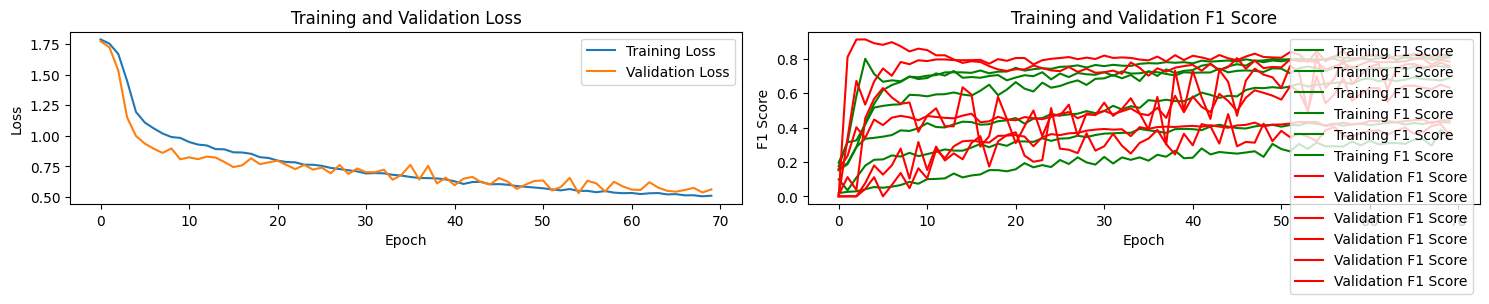

Train - Loss: 0.5088
Test  - Val Loss: 0.5605
Train - Mean F1 Score: 0.5332
Test - Mean Val F1 Score: 0.5411
67/67 [==============================] - 0s 2ms/step
Balanced Accuracy: 0.7896626681672942


In [ ]:
test_cnn1_improved_wW = cnn_improvedW.evaluate(X_validation, y_validation, verbose=1)
print('Test categorical:', test_cnn1_improved_wW[1])
print('Test f1:', test_cnn1_improved_wW[2])

check_results(cnn_model_improved_historyW)
bacc_final = bacc(cnn_improvedW , X_validation, y_validation)
print('Balanced Accuracy:', bacc_final)

### CNN improved - Balanced Data without class weights

In [51]:
def train_model_ag2(cnn, X_train, y_train, X_validation, y_validation, in_verbose):
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)  # Cast y_train to float32
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                      batch_size=512, epochs=200, shuffle=True, verbose=in_verbose,
                      callbacks=[early_stop, lr_callback])
    return history
#Batch Size: training examples (samples) that are processed in one forward
# and backward pass (iteration) through the neural network before the model's weights are updated.

In [46]:
cnn_improved_new = Improved_CNN()
X_train_ag2, y_train_ag2 = data_balance_generator(X_train, y_train, 6)
cnn_model_improved_history2 = train_model_ag2(cnn_improved_new, X_train_ag2, y_train_ag2, X_validation, y_validation, 0)
#Test f1: [0.86314714 0.518797   0.6        0.9260524  0.87317073 0.92682934]

67/67 [==============================] - 1s 6ms/step - loss: 0.3524 - categorical_accuracy: 0.8288 - f1_score: 0.7884
Test categorical: 0.8287864327430725
Test f1: [0.8681375  0.52427185 0.7123288  0.9004739  0.84322035 0.88220555]


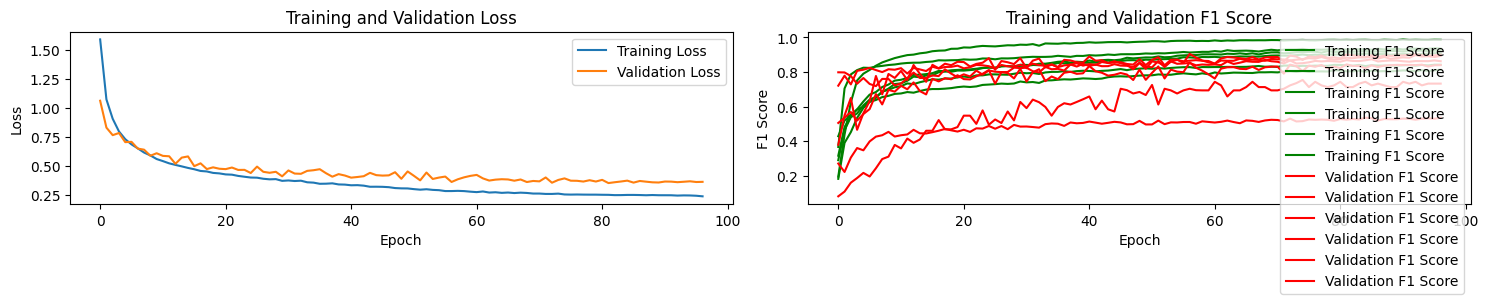

Train - Loss: 0.2385
Test  - Val Loss: 0.3630
Train - Mean F1 Score: 0.8415
Test - Mean Val F1 Score: 0.7301
67/67 [==============================] - 1s 6ms/step
Balanced Accuracy: 0.8496324011469832


In [18]:
test_cnn1_improved2 = cnn_improved_new.evaluate(X_validation, y_validation, verbose=1)
print('Test categorical:', test_cnn1_improved2[1])
print('Test f1:', test_cnn1_improved2[2])

check_results(cnn_model_improved_history2)
bacc_final = bacc(cnn_improved_new , X_validation, y_validation)
print('Balanced Accuracy:', bacc_final)


### Approach of separate both datasets

In [64]:
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from sklearn.metrics import balanced_accuracy_score

# Load your data
X, y, X_t = load_dias()
Xscaled, Xscaled_test = data_pre_processing(X, X_t)
train_labels, train_images, test_images = encoding(Xscaled, Xscaled_test)
train_images_s, train_labels_s = shuffling(Xscaled, train_images, train_labels)

# Split the data for dermoscopy and blood cell tasks
X_train, X_validation, y_train, y_validation = train_test_split(train_images_s, train_labels_s, test_size=0.2)

# Separate data into dermoscopy and blood cell categories
dermoscopy_indices = (y_train[:, :3] == 1).any(axis=1)
blood_cell_indices = (y_train[:, 3:] == 1).any(axis=1)

X_train_dermoscopy = X_train[dermoscopy_indices]
y_train_dermoscopy = y_train[dermoscopy_indices, :3]

X_test_dermoscopy = X_train[dermoscopy_indices]
y_test_dermoscopy = y_train[dermoscopy_indices, :3]

X_train_blood_cell = X_train[blood_cell_indices]
y_train_blood_cell = y_train[blood_cell_indices, 3:]

X_test_blood_cell = X_train[blood_cell_indices]
y_test_blood_cell = y_train[blood_cell_indices, 3:]


In [69]:
def Improved_CNN_dermoscopy():
    model = keras.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(28, 28, 3)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.4),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.4),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy',
                  metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.F1Score()])

    return model

model_dermoscopy = Improved_CNN_dermoscopy()
X_train_agD, y_train_agD = data_balance_generator(X_train_dermoscopy, y_train_dermoscopy, 3)
history_dermoscopy = train_model_ag2(model_dermoscopy, X_train_agD, y_train_agD, X_test_dermoscopy, y_test_dermoscopy, 0)


160/160 [==============================] - 1s 7ms/step - loss: 0.4795 - categorical_accuracy: 0.8984 - f1_score: 0.8128
Test categorical: 0.8984313607215881
Test f1: [0.9377263  0.7210966  0.77966106]


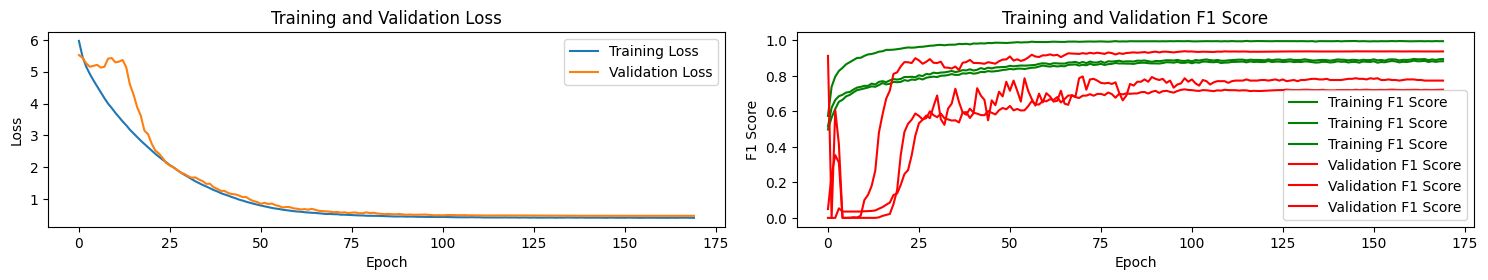

Train - Loss: 0.4166
Test  - Val Loss: 0.4796
Train - Mean F1 Score: 0.8900
Test - Mean Val F1 Score: 0.6987
67/67 [==============================] - 0s 3ms/step
Balanced Accuracy: 0.39700988582567526


In [70]:
test_dermoscopy = model_dermoscopy.evaluate(X_test_dermoscopy, y_test_dermoscopy, verbose=1)
print('Test categorical:', test_dermoscopy[1])
print('Test f1:', test_dermoscopy[2])

check_results(history_dermoscopy)
bacc_final = bacc(model_dermoscopy , X_test_dermoscopy, y_test_dermoscopy)
print('Balanced Accuracy:', bacc_final)


In [65]:
def Improved_CNN_blood_cell():
    #Replaced AveragePooling2D with MaxPooling2D for better feature selection.
    #Simplified by fewer dropout layers.
    cnn = keras.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(28, 28, 3)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(3, activation='softmax')
    ])

    cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
                metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.F1Score()])
    return cnn  # Add this line to return the model

model_blood_cell = Improved_CNN_blood_cell()
X_train_agB, y_train_agB = data_balance_generator(X_train_blood_cell, y_train_blood_cell, 3)
history_blood_cell = train_model_ag2(model_blood_cell, X_train_agB, y_train_agB, X_test_blood_cell, y_test_blood_cell, 0)

107/107 [==============================] - 1s 8ms/step - loss: 0.4627 - categorical_accuracy: 0.8158 - f1_score: 0.8131
Test categorical: 0.8157508373260498
Test f1: [0.8340452  0.75471693 0.85061723]


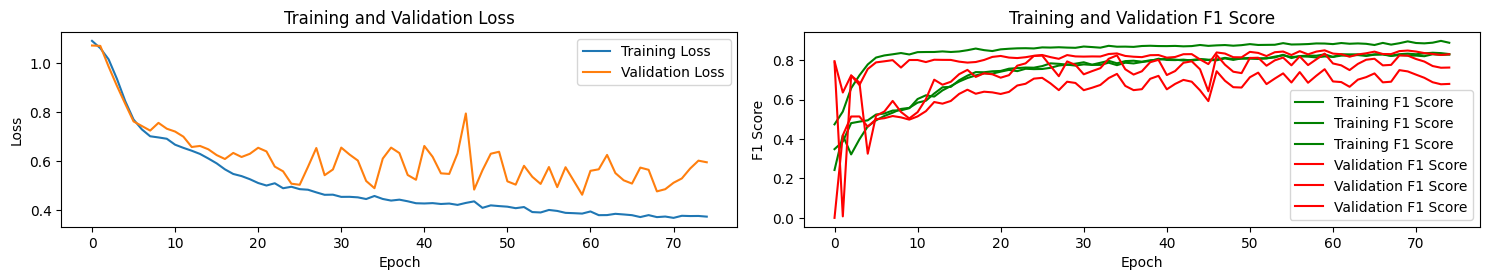

Train - Loss: 0.3734
Test  - Val Loss: 0.5950
Train - Mean F1 Score: 0.7788
Test - Mean Val F1 Score: 0.7303
67/67 [==============================] - 0s 2ms/step
Balanced Accuracy: 0.12051656920077973


In [67]:
test_blood_cell = model_blood_cell.evaluate(X_test_blood_cell, y_test_blood_cell, verbose=1)
print('Test categorical:', test_blood_cell[1])
print('Test f1:', test_blood_cell[2])

check_results(history_blood_cell)
bacc_final = bacc(model_blood_cell , X_test_blood_cell, y_test_blood_cell)
print('Balanced Accuracy:', bacc_final)

In [87]:
import numpy as np
from sklearn.metrics import balanced_accuracy_score

# Calculate predictions for the dermoscopy and blood cell models
y_pred_dermoscopy = model_dermoscopy.predict(X_test_dermoscopy)
y_pred_blood_cell = model_blood_cell.predict(X_test_blood_cell)

# Determine the size of the larger array
max_size = max(y_pred_dermoscopy.shape[0], y_pred_blood_cell.shape[0])

# Pad the smaller array with zeros to match the size of the larger array
if y_pred_dermoscopy.shape[0] < max_size:
    padding = np.zeros((max_size - y_pred_dermoscopy.shape[0], y_pred_dermoscopy.shape[1]))
    y_pred_dermoscopy = np.concatenate((y_pred_dermoscopy, padding), axis=0)
elif y_pred_blood_cell.shape[0] < max_size:
    padding = np.zeros((max_size - y_pred_blood_cell.shape[0], y_pred_blood_cell.shape[1]))
    y_pred_blood_cell = np.concatenate((y_pred_blood_cell, padding), axis=0)

# Combine the predictions
y_pred_combined = np.concatenate((y_pred_dermoscopy, y_pred_blood_cell), axis=1)

107/107 [==============================] - 0s 2ms/step
